In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import linearsolve as ls
np.set_printoptions(suppress=True)
%matplotlib inline

In [133]:
# Input model parameters
beta = np.exp(-2/100)
sigma= 1
kappa= 0.25

phiPi= 1.5
phiY = 0.5

rhoG = 0.25
rhoU = 0.35
rhoV = 0.5

yBar = 100
piT = 2
rho = 2

Sigma = 0.001*np.eye(3)

parameters = [beta,sigma,kappa,phiPi,phiY,rhoG,rhoU,rhoV]
parameterNames = ['beta','sigma','kappa','phiPi','phiY','rhoG','rhoU','rhoV']

def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
    
    # Exogenous demand
    g_proc =  p.rhoG*cur.g - fwd.g
    
    # Exogenous inflation
    u_proc =  p.rhoU*cur.u - fwd.u
    
    # Exogenous monetary policy
    v_proc =  p.rhoV*cur.v - fwd.v
    
    # Euler equation
    euler_eqn = fwd.y -1/p.sigma*(cur.i-fwd.pi) + cur.g - cur.y
    
    # NK Phillips curve evolution
    phillips_curve = p.beta*fwd.pi + p.kappa*cur.y + cur.u - cur.pi
    
    # interest rate rule
    interest_rule = p.phiY*cur.y+p.phiPi*cur.pi + cur.v - cur.i
    
    # Fisher equation
    fisher_eqn = cur.i - fwd.pi - cur.r
    
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
            g_proc,
            u_proc,
            v_proc,
            euler_eqn,
            phillips_curve,
            interest_rule,
            fisher_eqn
        ])

# Initialize the nk
nk = ls.model(equilibrium_equations,
              nstates=3,
              varNames=['g','u','v','i','r','y','pi'],
              shockNames=['eG','eU','eV'],
              parameters=parameters,
              parameterNames=parameterNames)

# Set the steady state of the nk
nk.set_ss([0,0,0,0,0,0,0])

# Find the log-linear approximation around the non-stochastic steady state
nk.log_linear_approximation(isloglinear=True)

# Solve the nk
nk.solve_klein(nk.a,nk.b)

In [134]:
a0 = yBar;
a1 = (1-beta*rhoG)/((1-beta*rhoG)*(1-rhoG+phiY/sigma)+ kappa/sigma*(phiPi-rhoG));
a2 = (rhoU-phiPi)/sigma  /  ((1-beta*rhoU)*(1-rhoU+phiY/sigma)+ kappa/sigma*(phiPi-rhoU));
a3 = -(1-beta*rhoV)/sigma/((1-beta*rhoV)*(1-rhoV+phiY/sigma)+ kappa/sigma*(phiPi-rhoV));

b0 = piT;
b1 = kappa/((1-beta*rhoG)*(1-rhoG+phiY/sigma)+ kappa/sigma*(phiPi-rhoG));
b2 = (1+kappa*a2)/(1-beta*rhoU)
b3 = -kappa/sigma/((1-beta*rhoV)*(1-rhoV+phiY/sigma)+ kappa/sigma*(phiPi-rhoV));
# b3 = sigma*kappa/((1-beta*rhoG)*(1-rhoG+phiY/sigma)+ kappa/sigma*(rhoG-phiPi));

c0 = rho+piT;
c1 = phiPi*b1 + phiY*a1;
c2 = phiPi*b2 + phiY*a2;
c3 = phiPi*b3 + phiY*a3 + 1;

d0 = rho
d1 = phiPi*b1 + phiY*a1 - rhoG*b1;
d2 = phiPi*b2 + phiY*a2 - rhoU*b2;
d3 = phiPi*b3 + phiY*a3 + 1 - rhoV*b3;

In [135]:
print('verify a1,a2, a3:')
print(a1-nk.f[2,0])
print(a2-nk.f[2,1])
print(a3-nk.f[2,2])

print('\n')
print('verify b1,b2, b3:')
print(b1-nk.f[3,0])
print(b2-nk.f[3,1])
print(b3-nk.f[3,2])

print('\n')
print('verify c1,c2, c3:')
print(c1-nk.f[0,0])
print(c2-nk.f[0,1])
print(c3-nk.f[0,2])

print('\n')
print('verify d1,d2, d3:')
print(d1-nk.f[1,0])
print(d2-nk.f[1,1])
print(d3-nk.f[1,2])

verify a1,a2, a3:
1.11022302463e-16
-2.22044604925e-16
1.11022302463e-16


verify b1,b2, b3:
1.94289029309e-16
1.55431223448e-15
-4.99600361081e-16


verify c1,c2, c3:
4.4408920985e-16
1.99840144433e-15
-1.38777878078e-16


verify d1,d2, d3:
3.33066907388e-16
1.44328993201e-15
1.11022302463e-16


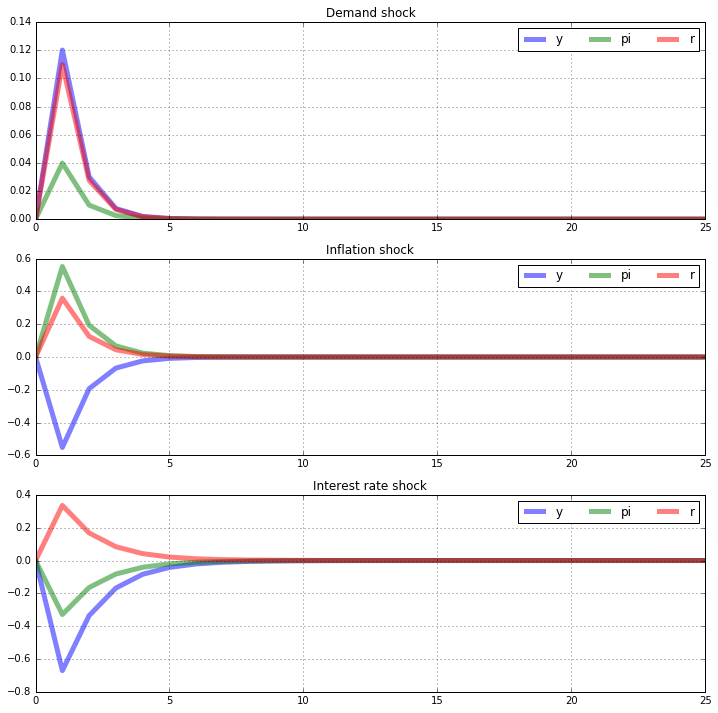

In [141]:


# Compute impulse responses and plot
nk.impulse(T=26,t0=1,shock=[0.2,0.5,1])

# Create the figure and axes
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# Plot commands
nk.irs['eG'][['y','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Demand shock',ax=ax1).legend(loc='upper right',ncol=5)
nk.irs['eU'][['y','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Inflation shock',ax=ax2).legend(loc='upper right',ncol=5)
nk.irs['eV'][['y','pi','r']].plot(lw='5',alpha=0.5,grid=True,title='Interest rate shock',ax=ax3).legend(loc='upper right',ncol=5)

